In [5]:
from binance.client import Client
from config_binance import api_mini, secretkey_mini
import pandas as pd
import datetime
client = Client(api_key=api_mini, api_secret=secretkey_mini)

In [12]:

time_res = client.get_server_time()
ptime = datetime.datetime.fromtimestamp(time_res["serverTime"] / 1000)
info = client.get_exchange_info()
status = client.get_system_status()
ptime, status

(datetime.datetime(2025, 2, 2, 18, 41, 35, 973000),
 {'status': 0, 'msg': 'normal'})

In [ ]:
tickers = client.get_all_tickers()

exchange_info = client.get_exchange_info()
symbols = [x['symbol'] for x in exchange_info['symbols']]
len(symbols), len(tickers)

intervals = {
    '15m': Client.KLINE_INTERVAL_15MINUTE,
    '1h':  Client.KLINE_INTERVAL_1HOUR,      
    '4h':  Client.KLINE_INTERVAL_4HOUR,
    '1d':  Client.KLINE_INTERVAL_1DAY
}

In [52]:
symbols[:5]

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH']

In [51]:
def get_binance_data(ticker, start='1 Jan 2024', interval='1d') -> pd.DataFrame:
    interval = intervals.get('1d')
    klines = client.get_historical_klines(symbol=ticker, interval=interval, start_str=start)
    data = pd.DataFrame(klines)
    data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
    data.index = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]
    usecols=['open', 'high', 'low', 'close', 'volume', 'qav','num_trades','taker_base_vol','taker_quote_vol']
    data = data[usecols]
    data = data.astype('float')
    return data

In [81]:
symbol = "NEOBTC"
df = get_binance_data(symbol)
df.head()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol
2024-01-01 00:00:00,0.000331,0.000349,0.000319,0.000322,43445.97,14.558886,5558.0,23043.15,7.726667
2024-01-02 00:00:00,0.000322,0.000325,0.000304,0.000309,35128.70,10.919400,2710.0,24362.63,7.564061
2024-01-03 00:00:00,0.000309,0.000313,0.000274,0.000289,52214.78,15.399829,5633.0,27702.02,8.164618
2024-01-04 00:00:00,0.000291,0.000300,0.000284,0.000292,21434.79,6.296576,2785.0,12154.19,3.578236
2024-01-05 00:00:00,0.000291,0.000292,0.000271,0.000278,16342.89,4.609949,1613.0,9110.94,2.573902


In [82]:
def backtest_rolling_basis(df: pd.DataFrame):
    # for index, row in df.iterrows():
    ...
    
def backtest_dataframe_wise(df: pd.DataFrame):
    
    df['daily_return'] = df['close']/df['open'] - 1
    
    # consecutive bars
    df['bull'] = (df['daily_return'] > 0).astype(int)
    df['consecutive_bull_bars'] = df['bull'].rolling(2).sum() == 2
    df['consecutive_bull_bars_signal'] = df['consecutive_bull_bars'].shift(1)
    # moving average domination
    df['5ma'] = df['close'].rolling(5).mean()
    df['20ma'] = df['close'].rolling(20).mean()
    df['5ma_signal'] = (df['5ma'].pct_change().shift(1) > 0).astype(int)

    df['signal'] = (df['5ma_signal'] == 1) & (df['consecutive_bull_bars_signal'] == 1)
    
    df['ret'] = df['signal'] * df['daily_return']
    
    return df

<Axes: >

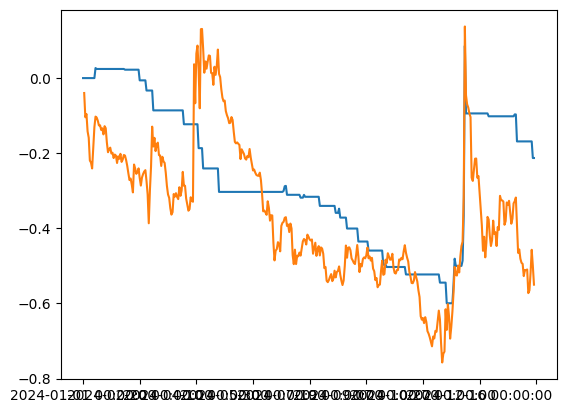

In [83]:
df1 = backtest_dataframe_wise(df)
df1['ret'].cumsum().plot()
df1['close'].pct_change().cumsum().plot()

<Axes: >

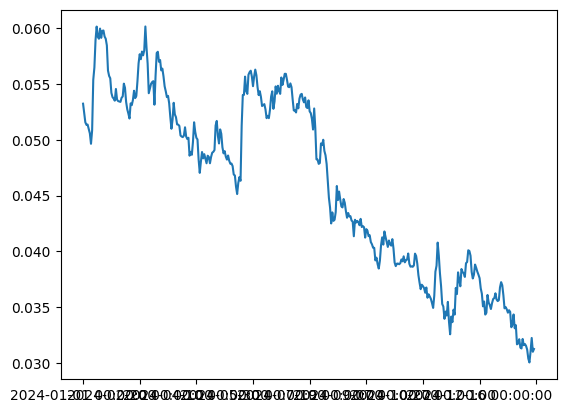

In [57]:
df['close'].plot()

In [44]:
# # get data from yfinance
# import requests
# from requests_html import HTMLSession
# session = HTMLSession()
# # num_currencies=len(symbols)
# num_currencies=250
# resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
# tables = pd.read_html(resp.html.raw_html)               
# df = tables[0].copy()
# symbols_yf = df.Symbol.tolist()
# print(symbols_yf[:15])

2917